Red neuronal que clasifica imagenes entre tipos de verduras

# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

D:\machine_learning\anaconda\envs\DP-Python39\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\pablo\AppData\Local\Temp\ipykernel_17184\3769120664.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from keras.utils import image_dataset_from_directory

In [4]:
from tensorflow.data.experimental import cardinality

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers


In [6]:
from keras.callbacks import TensorBoard
%load_ext tensorboard


In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
from kerastuner.tuners import RandomSearch

# Funciones

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, data_aug_fun):
  ds = ds.map(lambda x, y: (data_aug_fun(x), y), 
              num_parallel_calls=AUTOTUNE)

  # if shuffle:
  #   ds = ds.shuffle(1000)

  # Batch all datasets.
  # ds = ds.batch(batch_size)

    
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

# Configuración

Diferentes confiugraciones respectivas a los datos y las redes

In [10]:
# loss_fun = 'binary_crossentropy'
# out_layer_neurons = 1
# out_layer_activ = 'sigmoid'
# ds_label_mode = 'int'

loss_fun = 'categorical_crossentropy'
out_layer_neurons = 15
out_layer_activ = 'softmax'
ds_label_mode = 'categorical'

# Métodos para visualización

In [11]:
def plot_examples(dataset):
    plt.figure(figsize=(10, 10))
    # Take devuelve un batch aleatorio de 32 objetos. Siendo estos objetos un par de matriz de pixeles y label
    print(dataset)
    for images, labels in dataset.take(2):
    
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # if i == 0:
        #     print(images[i].numpy().astype("uint8"))
        # plt.imshow(images[i].numpy().astype("uint8"))
        plt.imshow(images[i].numpy())
        # Si se ha hecho onehot encoding con las labels
        if labels.dtype == 'float32':
            label = tf.argmax(labels[i].numpy(), axis=0)
            # plt.title(class_names[label.numpy()])
            plt.title(f"{label.numpy()} {class_names[label.numpy()]}")
        # Si las labels son un numero
        elif labels.dtype == 'int32':
            plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.plot()

In [12]:
def show_curves(train, type):
    pd.DataFrame(train.history)[[type, f'val_{type}']].plot(figsize=(10, 6))
    plt.grid(True)
    plt.xlabel("epochs")
    plt.ylabel(type)
    plt.show()

def show_loss_acc(ds):
    show_curves(ds, 'loss')
    show_curves(ds, 'accuracy')
    

In [13]:
def show_image(ds, batch, img_num):
    # Solo devuelve el primer batch siempre, arreglar
    image = ds.take(1)
    img = next(iter(image))[0]
    plt.imshow(img[img_num].numpy().astype("uint8"))

# Carga de datos

## Datos entrenamiento

Aquí hay un ejemplo de técnicas a utilizar: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

In [14]:
image_path = 'datasets\Vegetable Images'

In [15]:
batch_size = 32
img_height = 128
img_width = 128

Sobre tamaños de imagen comunes en RNC:

- **32x32 o 64x64**: Para tareas simples o datasets como CIFAR-10/100.
- **128x128 o 224x224**: Tamaños comunes que ofrecen un buen balance entre detalle y carga computacional.
- **299x299 o más**: Para tareas que requieren mucha precisión y donde el hardware lo permite, como modelos Inception o análisis de imágenes de alta resolución.

In [16]:
train_ds = image_dataset_from_directory(
  image_path+"/train",
  # validation_split=1,
  # subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=ds_label_mode,
)

Found 15000 files belonging to 15 classes.


In [17]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

- image_size cambia el tamaño de todas las imágenes directamente
- batch size agrupa los datos en batches
- label mode cambia el formato de las labels. Al ponerlo en categorical, se hace one hot encoding automáticamente.

In [18]:
print(cardinality(train_ds).numpy())

469


In [19]:
class_names = train_ds.class_names
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

## Visualizar datos de entrenamiento

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.46875..253.45312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..236.75].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [8.578125..224.89062].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..248.75].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.890625..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..215.29688].
Clipping input data to the valid r

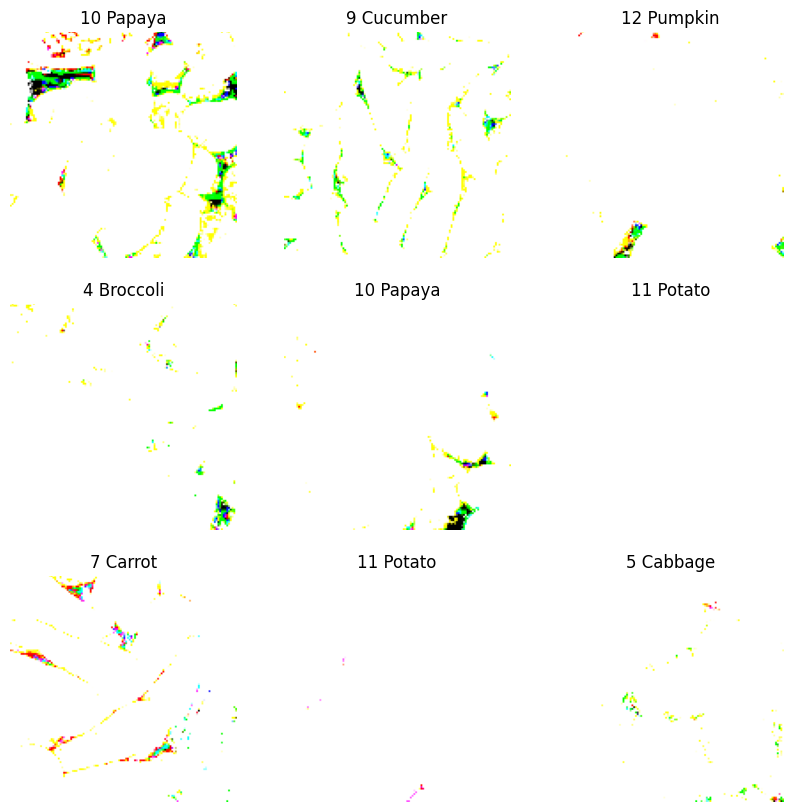

In [20]:
plot_examples(train_ds)

## Cargar conjunto validación y test

Cargamos en un dataset de tensorflow las imagenes de test.

In [21]:
val_ds = image_dataset_from_directory(
  image_path+"/validation",
  # validation_split=0.5,
  # subset="training",
  # seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=ds_label_mode
)

Found 3000 files belonging to 15 classes.


De la siguiente forma las dividiremos en set de validation y test.

In [22]:
test_ds = image_dataset_from_directory(
  image_path+"/test",
  # validation_split=0.5,
  # subset="validation",
  # seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=ds_label_mode
)

Found 3000 files belonging to 15 classes.


In [23]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.296875..217.60938].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..227.75].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..239.10938].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.140625..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..230.14062].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..227.625].
Clipping input data to the valid rang

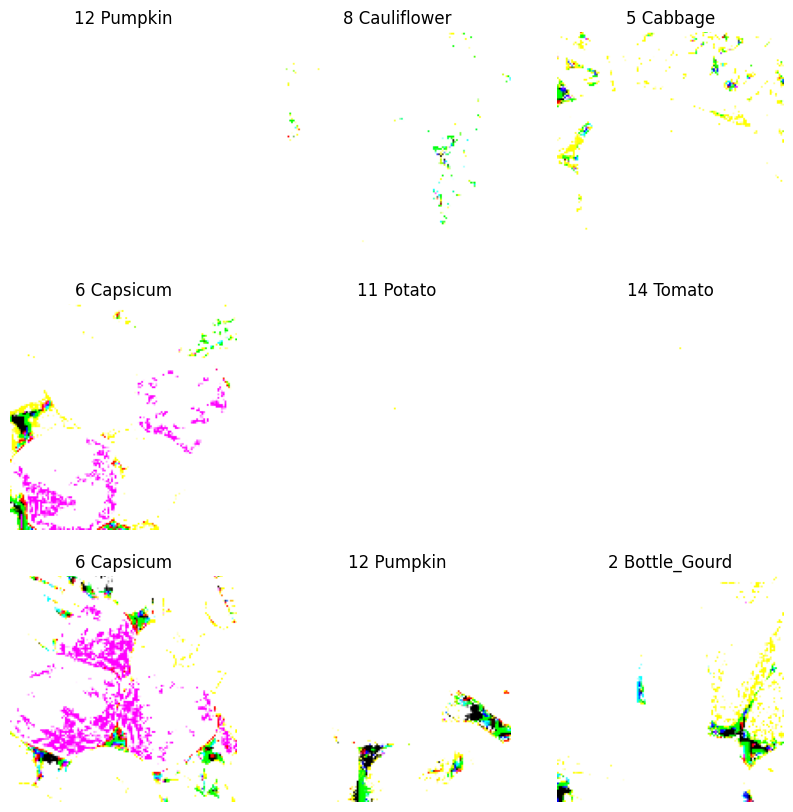

In [24]:
plot_examples(val_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..235.125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.671875..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.65625..254.10938].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..223.40625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..244.95312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..238.17188].
Clipping input data to the valid ra

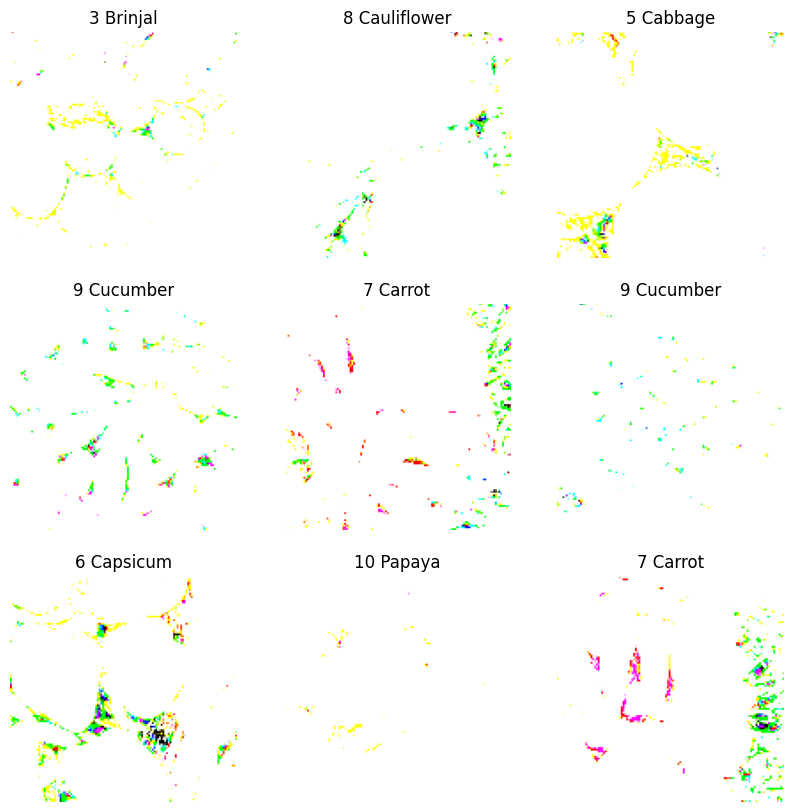

In [25]:
plot_examples(test_ds)


In [26]:
print(cardinality(val_ds).numpy())
print(cardinality(test_ds).numpy())

94
94


# Preparación de los datos

In [27]:
# Si el rescaling se hace en el modelo, tensorflowjs da fallo
rescale = keras.Sequential([
    layers.Rescaling(1./255)
])

train_ds = prepare(train_ds, rescale)
val_ds = prepare(val_ds, rescale)
test_ds = prepare(test_ds, rescale)

In [28]:


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Entrenamiento de la red neuronal

## Primera red neuronal

In [69]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(out_layer_neurons, activation=out_layer_activ)
])

In [70]:
model.compile(
  optimizer='adam',
  # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss=loss_fun,
  metrics=['accuracy', 'Precision'])

In [71]:
tensorboardRC1 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainRC1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[tensorboardRC1]
)

Epoch 1/10
469/469 [==============================] - 17s 34ms/step - loss: 0.9770 - accuracy: 0.6851 - precision: 0.8549 - val_loss: 0.4111 - val_accuracy: 0.8737 - val_precision: 0.9194
Epoch 2/10
469/469 [==============================] - 15s 32ms/step - loss: 0.2682 - accuracy: 0.9181 - precision: 0.9422 - val_loss: 0.4379 - val_accuracy: 0.8673 - val_precision: 0.8916
Epoch 3/10
469/469 [==============================] - 14s 31ms/step - loss: 0.1282 - accuracy: 0.9615 - precision: 0.9707 - val_loss: 0.3390 - val_accuracy: 0.9067 - val_precision: 0.9194
Epoch 4/10
469/469 [==============================] - 14s 31ms/step - loss: 0.0694 - accuracy: 0.9797 - precision: 0.9833 - val_loss: 0.3083 - val_accuracy: 0.9247 - val_precision: 0.9347
Epoch 5/10
469/469 [==============================] - 14s 31ms/step - loss: 0.0512 - accuracy: 0.9853 - precision: 0.9872 - val_loss: 0.2989 - val_accuracy: 0.9290 - val_precision: 0.9381
Epoch 6/10
469/469 [==============================] - 14s 31

## Segunda red neuronal

Añadimos dropout para reducir aun más el overfitting

In [64]:
initializer = keras.initializers.HeNormal()

In [84]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
    
  layers.Dropout(0.5),
  tf.keras.layers.Dense(out_layer_neurons, activation=out_layer_activ)
])

In [85]:
model.compile(
  optimizer='adam',
  # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss=loss_fun,
  metrics=['accuracy', 'Precision'],

)

In [86]:
tensorboardRC1 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainRC1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[tensorboardRC1],
)

Epoch 1/10
469/469 [==============================] - 19s 40ms/step - loss: 1.7077 - accuracy: 0.4239 - precision: 0.7402 - val_loss: 0.8656 - val_accuracy: 0.7223 - val_precision: 0.8861
Epoch 2/10
469/469 [==============================] - 18s 39ms/step - loss: 0.9306 - accuracy: 0.6917 - precision: 0.8180 - val_loss: 0.5239 - val_accuracy: 0.8440 - val_precision: 0.9140
Epoch 3/10
469/469 [==============================] - 19s 39ms/step - loss: 0.6599 - accuracy: 0.7832 - precision: 0.8626 - val_loss: 0.3767 - val_accuracy: 0.8963 - val_precision: 0.9470
Epoch 4/10
469/469 [==============================] - 19s 39ms/step - loss: 0.5240 - accuracy: 0.8315 - precision: 0.8889 - val_loss: 0.2675 - val_accuracy: 0.9287 - val_precision: 0.9616
Epoch 5/10
469/469 [==============================] - 18s 39ms/step - loss: 0.4393 - accuracy: 0.8546 - precision: 0.8997 - val_loss: 0.2500 - val_accuracy: 0.9230 - val_precision: 0.9498
Epoch 6/10
469/469 [==============================] - 19s 40

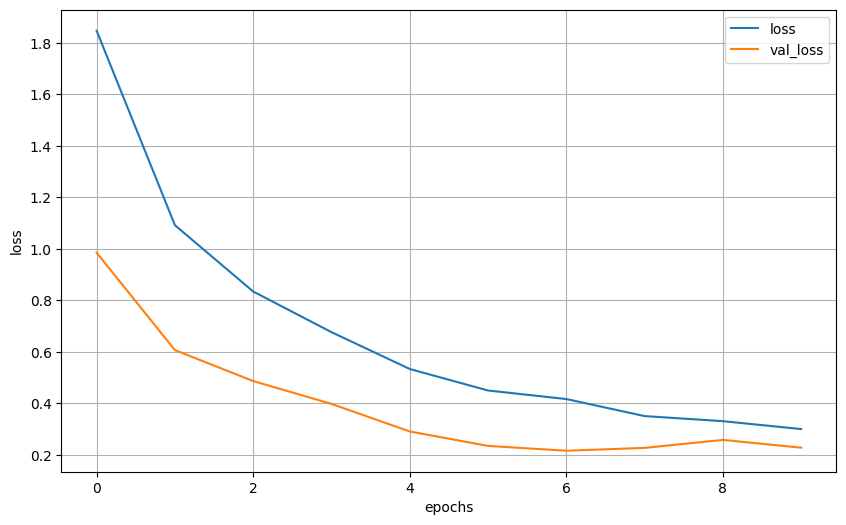

In [82]:
show_curves(trainRC1, 'loss')

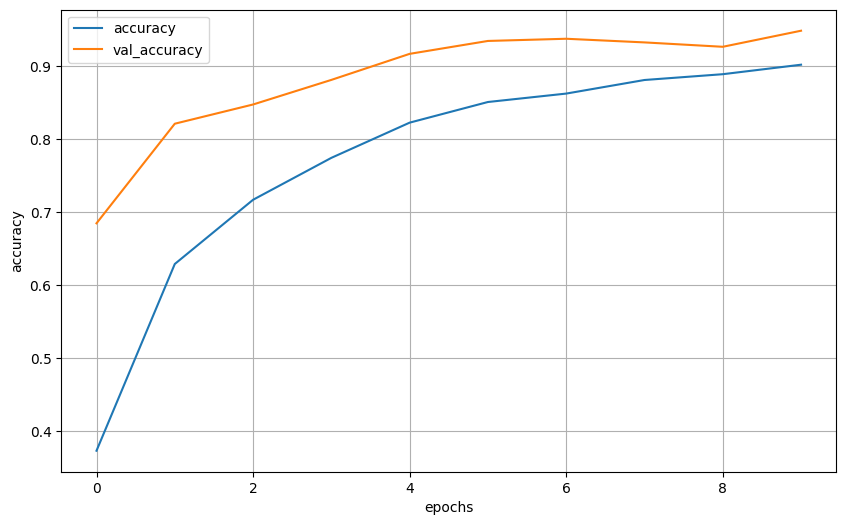

In [83]:
show_curves(trainRC1, 'accuracy')

## Inicialización de pesos

Comprobamos si se producen mejores resultados con una inicialización de pesos.

In [110]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3), kernel_initializer="he_normal"),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer="he_normal"),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(128, 3, activation='relu', kernel_initializer="he_normal"),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
    
  layers.Dropout(0.5),
  tf.keras.layers.Dense(out_layer_neurons, activation=out_layer_activ, kernel_initializer="glorot_normal")
])

In [111]:
initializer = keras.initializers.HeNormal()

In [112]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
    
  layers.Dropout(0.5),
  tf.keras.layers.Dense(out_layer_neurons, activation=out_layer_activ)
])

In [113]:
model.compile(
  optimizer='adam',
  # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss=loss_fun,
  metrics=['accuracy', 'Precision'],

)

In [114]:
tensorboardRC1 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainRC1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[tensorboardRC1],
)

Epoch 1/10
469/469 [==============================] - 19s 40ms/step - loss: 1.8933 - accuracy: 0.3480 - precision: 0.6816 - val_loss: 1.0650 - val_accuracy: 0.6600 - val_precision: 0.8638
Epoch 2/10
469/469 [==============================] - 18s 39ms/step - loss: 1.1950 - accuracy: 0.5924 - precision: 0.7854 - val_loss: 0.6013 - val_accuracy: 0.8303 - val_precision: 0.9212
Epoch 3/10
469/469 [==============================] - 18s 39ms/step - loss: 0.9127 - accuracy: 0.6883 - precision: 0.8276 - val_loss: 0.4559 - val_accuracy: 0.8700 - val_precision: 0.9378
Epoch 4/10
469/469 [==============================] - 18s 39ms/step - loss: 0.7186 - accuracy: 0.7556 - precision: 0.8562 - val_loss: 0.3772 - val_accuracy: 0.8910 - val_precision: 0.9399
Epoch 5/10
469/469 [==============================] - 18s 39ms/step - loss: 0.5854 - accuracy: 0.8029 - precision: 0.8817 - val_loss: 0.2865 - val_accuracy: 0.9243 - val_precision: 0.9561
Epoch 6/10
469/469 [==============================] - 18s 39

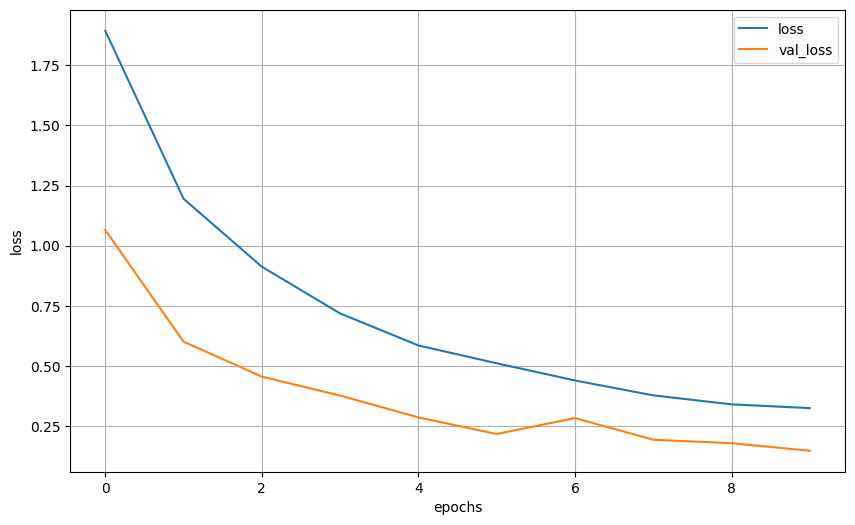

In [115]:
show_curves(trainRC1, 'loss')

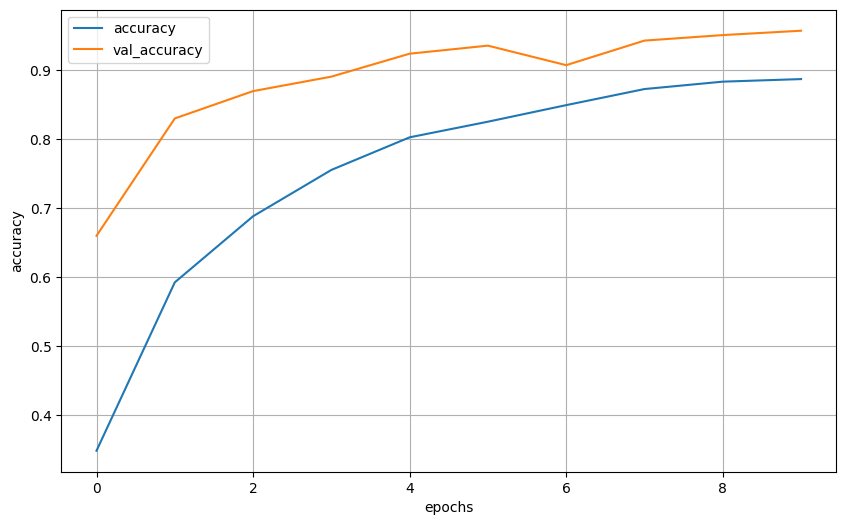

In [116]:
show_curves(trainRC1, 'accuracy')

No se producen mejores resultados

## Método para construir red

In [29]:
# Guardamos las capas de la red neuronal para utilizarla con los próximos ejemplos
def create_model(color_scale=3):
    # rescaling_layer = tf.keras.layers.Rescaling(1./255, input_shape=(128, 128, color_scale))
    # if color_scale == 1:
    #     rescaling_layer = tf.keras.layers.Rescaling(1./255)
        
    model = keras.Sequential([
      # tf.keras.layers.Rescaling(1./255, input_shape=(128, 128, color_scale)),
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, color_scale)),
      tf.keras.layers.MaxPooling2D(),
      layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      layers.Dropout(0.2),
      tf.keras.layers.Conv2D(128, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      tf.keras.layers.Dense(out_layer_neurons, activation=out_layer_activ)
    ])
    model.compile(
    optimizer='adam',
    loss=loss_fun,
    metrics=['accuracy', 'Precision'])
    return model

# Mejora de resultados

## Data augmentation

In [44]:
# datagen = ImageDataGenerator(
#     height_shift_range=.5,
#     width_shift_range=.5,
#     zoom_range=[.75,1.5],
#     rotation_range=30,
# )

trans_shift = 0.3

data_aug = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.3),
    layers.RandomTranslation((-trans_shift, trans_shift), (-trans_shift, trans_shift), fill_mode="constant", fill_value=0),
])




In [45]:
aug_ds = prepare(train_ds, data_aug)
aug_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

## Comprobaciones dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>


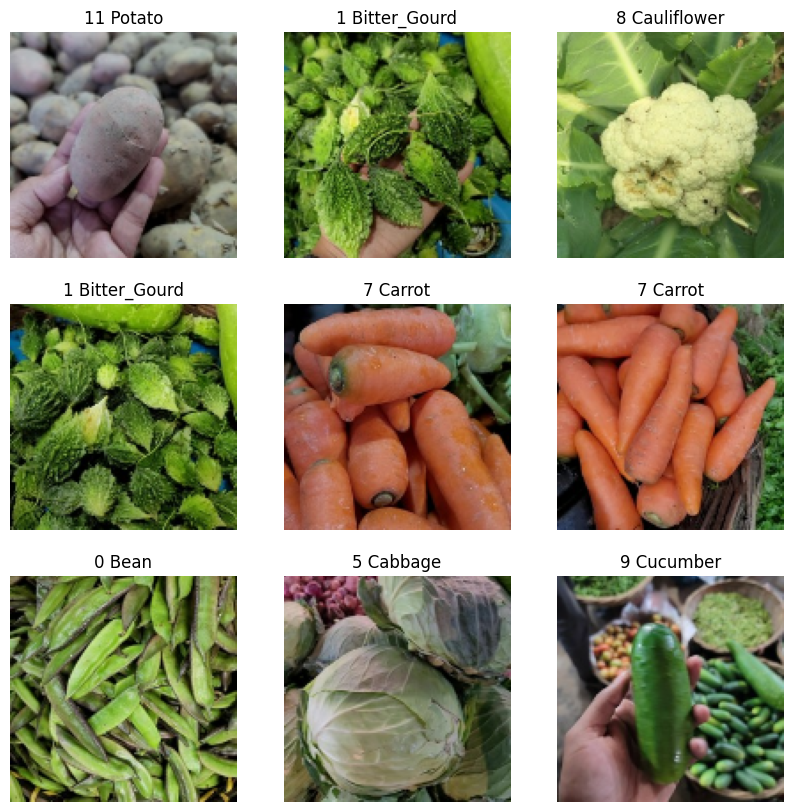

In [47]:
plot_examples(aug_ds)

## Entrenamiento

Ahora entrenaremos la misma red neuronal con estos datos nuevos

In [48]:
modelAUG1 = create_model()

In [49]:
tensorboardAUG = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainAUG = modelAUG1.fit(
  aug_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[tensorboardAUG],
)

Epoch 1/10
469/469 [==============================] - 25s 52ms/step - loss: 1.8050 - accuracy: 0.3914 - precision: 0.7198 - val_loss: 1.1045 - val_accuracy: 0.6203 - val_precision: 0.7638
Epoch 2/10
469/469 [==============================] - 24s 52ms/step - loss: 1.0208 - accuracy: 0.6582 - precision: 0.8055 - val_loss: 0.6073 - val_accuracy: 0.8047 - val_precision: 0.8902
Epoch 3/10
469/469 [==============================] - 25s 53ms/step - loss: 0.7515 - accuracy: 0.7525 - precision: 0.8503 - val_loss: 0.4396 - val_accuracy: 0.8687 - val_precision: 0.9188
Epoch 4/10
469/469 [==============================] - 25s 53ms/step - loss: 0.6176 - accuracy: 0.7935 - precision: 0.8708 - val_loss: 0.4565 - val_accuracy: 0.8520 - val_precision: 0.9010
Epoch 5/10
469/469 [==============================] - 24s 52ms/step - loss: 0.5085 - accuracy: 0.8301 - precision: 0.8892 - val_loss: 0.3095 - val_accuracy: 0.9113 - val_precision: 0.9411
Epoch 6/10
469/469 [==============================] - 23s 50

In [50]:
modelAUG1.evaluate(test_ds)

94/94 [==============================] - 3s 31ms/step - loss: 0.2226 - accuracy: 0.9377 - precision: 0.9516


[0.22256648540496826, 0.937666654586792, 0.9515630602836609]

## Segunda data augmentation

In [148]:
trans_shift = 0.3

data_aug2 = keras.Sequential([
    # layers.RandomFlip("horizontal_and_vertical"),
    # layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation((-trans_shift, trans_shift), (-trans_shift, trans_shift), fill_mode="constant", fill_value=0),
])

aug_ds2 = prepare(train_ds, data_aug2)
aug_ds2

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [149]:
modelAUG = create_model()

In [150]:
tensorboardAUG2 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainAUG = modelAUG.fit(
  aug_ds2,
  validation_data=val_ds,
  epochs=15,
  callbacks=[tensorboardAUG2]
)

Epoch 1/15
469/469 [==============================] - 19s 40ms/step - loss: 1.7378 - accuracy: 0.4156 - precision: 0.7299 - val_loss: 1.0078 - val_accuracy: 0.6740 - val_precision: 0.8745
Epoch 2/15
469/469 [==============================] - 19s 41ms/step - loss: 1.0019 - accuracy: 0.6698 - precision: 0.8116 - val_loss: 0.6022 - val_accuracy: 0.8077 - val_precision: 0.8928
Epoch 3/15
469/469 [==============================] - 19s 40ms/step - loss: 0.7069 - accuracy: 0.7689 - precision: 0.8544 - val_loss: 0.4339 - val_accuracy: 0.8797 - val_precision: 0.9250
Epoch 4/15
469/469 [==============================] - 19s 41ms/step - loss: 0.5400 - accuracy: 0.8248 - precision: 0.8806 - val_loss: 0.3362 - val_accuracy: 0.9083 - val_precision: 0.9463
Epoch 5/15
469/469 [==============================] - 19s 40ms/step - loss: 0.4549 - accuracy: 0.8485 - precision: 0.8993 - val_loss: 0.2623 - val_accuracy: 0.9233 - val_precision: 0.9494
Epoch 6/15
469/469 [==============================] - 18s 39

## Tercera data augmentation

In [151]:
data_aug3 = keras.Sequential([
    layers.RandomFlip("horizontal"),
    # layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    # layers.RandomTranslation((-trans_shift, trans_shift), (-trans_shift, trans_shift), fill_mode="constant", fill_value=0),
])

aug_ds3 = prepare(train_ds, data_aug3)
aug_ds3

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [152]:
modelAUG = create_model()

In [153]:
tensorboardAUG2 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainAUG = modelAUG.fit(
  aug_ds3,
  validation_data=val_ds,
  epochs=15,
  callbacks=[tensorboardAUG2]
)

Epoch 1/15
469/469 [==============================] - 19s 40ms/step - loss: 1.7166 - accuracy: 0.4253 - precision: 0.7473 - val_loss: 1.0277 - val_accuracy: 0.6967 - val_precision: 0.8653
Epoch 2/15
469/469 [==============================] - 19s 41ms/step - loss: 0.9835 - accuracy: 0.6732 - precision: 0.8131 - val_loss: 0.6494 - val_accuracy: 0.8073 - val_precision: 0.9026
Epoch 3/15
469/469 [==============================] - 19s 41ms/step - loss: 0.7287 - accuracy: 0.7588 - precision: 0.8508 - val_loss: 0.3728 - val_accuracy: 0.9030 - val_precision: 0.9485
Epoch 4/15
469/469 [==============================] - 19s 41ms/step - loss: 0.5707 - accuracy: 0.8131 - precision: 0.8795 - val_loss: 0.3240 - val_accuracy: 0.9130 - val_precision: 0.9370
Epoch 5/15
469/469 [==============================] - 19s 40ms/step - loss: 0.4627 - accuracy: 0.8454 - precision: 0.8990 - val_loss: 0.2477 - val_accuracy: 0.9287 - val_precision: 0.9527
Epoch 6/15
469/469 [==============================] - 19s 40

## Grayscale

### Entrenamiento

In [38]:

# De esta forma podemos pasar transformaciones de tf.image a capas
grayscale_layer = tf.keras.layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x))

gray = keras.Sequential([
    grayscale_layer
])

gray_ds = prepare(train_ds, gray)
gray_ds


modelGray = create_model(1)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>


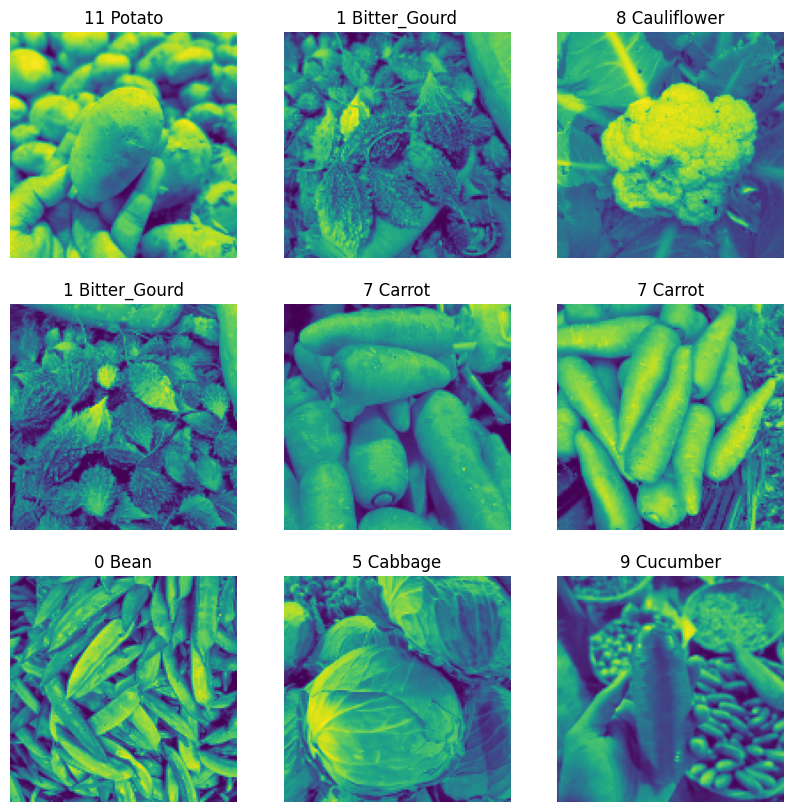

In [39]:
plot_examples(gray_ds)

In [40]:
val_gray_ds = prepare(val_ds, gray)

In [41]:
tensorboardGray = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainGray = modelGray.fit(
  gray_ds,
  validation_data=val_gray_ds,
  epochs=15,
  callbacks=[tensorboardGray]
)

Epoch 1/15
469/469 [==============================] - 26s 53ms/step - loss: 2.2278 - accuracy: 0.2706 - precision: 0.6422 - val_loss: 1.6459 - val_accuracy: 0.5367 - val_precision: 0.8393
Epoch 2/15
469/469 [==============================] - 26s 55ms/step - loss: 1.6212 - accuracy: 0.4757 - precision: 0.7361 - val_loss: 1.1975 - val_accuracy: 0.6260 - val_precision: 0.8494
Epoch 3/15
469/469 [==============================] - 25s 52ms/step - loss: 1.3204 - accuracy: 0.5687 - precision: 0.7841 - val_loss: 0.9366 - val_accuracy: 0.7307 - val_precision: 0.9171
Epoch 4/15
469/469 [==============================] - 25s 53ms/step - loss: 1.0860 - accuracy: 0.6448 - precision: 0.8175 - val_loss: 0.6969 - val_accuracy: 0.8010 - val_precision: 0.9396
Epoch 5/15
469/469 [==============================] - 24s 52ms/step - loss: 0.9289 - accuracy: 0.6923 - precision: 0.8358 - val_loss: 0.5991 - val_accuracy: 0.8307 - val_precision: 0.9272
Epoch 6/15
469/469 [==============================] - 24s 52

### Data augmentation

In [136]:
data_aug_gray = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    # layers.RandomTranslation((-trans_shift, trans_shift), (-trans_shift, trans_shift), fill_mode="constant", fill_value=0),
])

train_gray_aug_ds = prepare(gray_ds, data_aug_gray)
# val_gray_aug_ds = prepare(val_gray_ds, data_aug_gray)

NameError: name 'gray_ds' is not defined

In [137]:
plot_examples(train_gray_aug_ds)

NameError: name 'train_gray_aug_ds' is not defined

In [139]:
modelGray = create_model(1)

In [140]:
tensorboardGrayFit = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainGray = modelGray.fit(
  train_gray_aug_ds,
  validation_data=val_gray_ds,
  epochs=15,
  callbacks=[tensorboardGrayFit]
)

Epoch 1/15
469/469 [==============================] - 19s 38ms/step - loss: 2.2994 - accuracy: 0.2263 - precision: 0.5989 - val_loss: 1.7530 - val_accuracy: 0.4397 - val_precision: 0.7333
Epoch 2/15
469/469 [==============================] - 18s 38ms/step - loss: 1.6372 - accuracy: 0.4623 - precision: 0.7317 - val_loss: 1.1113 - val_accuracy: 0.6653 - val_precision: 0.9085
Epoch 3/15
469/469 [==============================] - 18s 38ms/step - loss: 1.2440 - accuracy: 0.5865 - precision: 0.7910 - val_loss: 0.8104 - val_accuracy: 0.7573 - val_precision: 0.8957
Epoch 4/15
469/469 [==============================] - 18s 38ms/step - loss: 1.0005 - accuracy: 0.6683 - precision: 0.8221 - val_loss: 0.6385 - val_accuracy: 0.8033 - val_precision: 0.9198
Epoch 5/15
469/469 [==============================] - 18s 38ms/step - loss: 0.8429 - accuracy: 0.7165 - precision: 0.8435 - val_loss: 0.5152 - val_accuracy: 0.8390 - val_precision: 0.9289
Epoch 6/15
469/469 [==============================] - 18s 38

No mejora mucho con este data augmentation. Cambiamos algunos parámetros:

In [141]:
data_aug_gray = keras.Sequential([
    # layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    # layers.RandomTranslation((-trans_shift, trans_shift), (-trans_shift, trans_shift), fill_mode="constant", fill_value=0),
])

train_gray_aug_ds = prepare(gray_ds, data_aug_gray)
# val_gray_aug_ds = prepare(val_gray_ds, data_aug_gray)

modelGray = create_model(1)

In [142]:
tensorboardGrayFit = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainGray = modelGray.fit(
  train_gray_aug_ds,
  validation_data=val_gray_ds,
  epochs=15,
  callbacks=[tensorboardGrayFit]
)

Epoch 1/15
469/469 [==============================] - 20s 41ms/step - loss: 2.2149 - accuracy: 0.2693 - precision: 0.6465 - val_loss: 1.4775 - val_accuracy: 0.5443 - val_precision: 0.8532
Epoch 2/15
469/469 [==============================] - 19s 41ms/step - loss: 1.5333 - accuracy: 0.5079 - precision: 0.7489 - val_loss: 1.0019 - val_accuracy: 0.7107 - val_precision: 0.8984
Epoch 3/15
469/469 [==============================] - 19s 41ms/step - loss: 1.2046 - accuracy: 0.6075 - precision: 0.7965 - val_loss: 0.7941 - val_accuracy: 0.7650 - val_precision: 0.9193
Epoch 4/15
469/469 [==============================] - 19s 41ms/step - loss: 1.0022 - accuracy: 0.6712 - precision: 0.8264 - val_loss: 0.6082 - val_accuracy: 0.8200 - val_precision: 0.9218
Epoch 5/15
469/469 [==============================] - 19s 41ms/step - loss: 0.8925 - accuracy: 0.6972 - precision: 0.8375 - val_loss: 0.5911 - val_accuracy: 0.8273 - val_precision: 0.9299
Epoch 6/15
469/469 [==============================] - 19s 41

### Conclusión

Los colores son muy importantes para las verduras, lo que da malos resultados si se pasa a gris

# Exportar modelo

Exportamos el modelo que mejor ha dado resultado

In [52]:
modelAUG1.save('vegetables.h5')

# Keras Tuner

In [25]:
def model_builder(hp):
    # Definición del modelo
    model = keras.Sequential()

    # input layer
    model.add(layers.Conv2D(hp.Int('input_units',
        min_value=32,
        max_value=256,
        step=32), (3, 3), input_shape=(128, 128, 3)))

    dropout_size = hp.Choice('dropout', [0, 0.25, 0.5, 0.75])
    
    # Hidden conv layers 
    for i in range(hp.Int('n_layers', 1, 4)):
        # Añadimos la hidden layer
        model.add(layers.Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3)))
        model.add(layers.MaxPooling2D())
        model.add(layers.Dropout(dropout_size)),

    model.add(layers.Flatten())
    
    # Tuning del número de neuronas de las hidden layer
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    
    # Tuning del número de capas
    hp_layers = hp.Int('layers', min_value=1, max_value=5, step=1)

     # Hidden layers 
    for i in range(hp_layers):
        model.add(layers.Dense(units=hp_units, activation='relu'))
        model.add(layers.Dropout(0.5)),
        
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
   
    
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [36]:
tuner = kt.Hyperband(
    model_builder,
    objective= 'val_accuracy',
    max_epochs=10,
    overwrite=True,
    factor=3,
    directory='hp_dir',
    project_name='cats_vs_dogs_tuner'
)

ValueError: Unrecognized arguments ['max_epochs', 'factor'] for `BaseTuner.__init__()`.

In [26]:
tuner = RandomSearch(
    model_builder,
    objective='val_acc',
    max_trials=5,  # how many model variations to test?
    executions_per_trial=3,  # how many trials per variation? (same model could perform differently)
    directory='hp_dir',
    project_name='cats_vs_dogs_tuner')

Reloading Tuner from hp_dir\cats_vs_dogs_tuner\tuner0.json


In [27]:
tuner.search(
    x=train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size,
)


Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |32                |input_units
0.75              |0.75              |dropout
4                 |4                 |n_layers
96                |96                |conv_0_units
16                |16                |units
5                 |5                 |layers
0.001             |0.001             |learning_rate
32                |32                |conv_1_units
224               |224               |conv_2_units

Epoch 1/10
250/250 [==============================] - 35s 123ms/step - loss: 0.7301 - accuracy: 0.5070 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 2/10
250/250 [==============================] - 22s 87ms/step - loss: 0.6954 - accuracy: 0.4969 - val_loss: 0.6930 - val_accuracy: 0.5060
Epoch 3/10
250/250 [==============================] - 22s 87ms/step - loss: 0.6935 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 4/10
250/250 [=============================


KeyboardInterrupt





# Tensorboard

In [53]:
%reload_ext tensorboard

In [54]:
%tensorboard --logdir logs/fit --host localhost

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
D:\machine_learning\anaconda\envs\DP-Python39\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Traceback (most recent call last):
  File "D:\machine_learning\anaconda\envs\DP-Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "D:\machine_learning\anaconda\envs\DP-Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "D:\machine_learning\anaconda\envs\DP-Python39\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "C:\Users\pablo\AppData\Roaming\Python\Python39\site-packages\tensorboard\main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "D:\machine_learning\anaconda\envs\DP-Python39\lib\site-packages\absl\app.py", line 308, in run
    _run

# Conclusión.

Este dataset está formado por imágenes demasiado parecidas entre sí, lo que provoca que realizar tareas de clasificación sea muy complicado, incluso utilizando data augmentation.

Los altos valores de los resultados significa que las imágenes son demasiado parecidas entre sí.